In [64]:
import cloudscraper
import re
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(8281)

# Exploring NFL odds
I'm looking at NFL odds, particularly the question of how the betting public does betting on the NFL. The question, that I've previously asked about the NBA, is do they do better or worse than a coin flip?


## getting the data
I'm trying to get NFL odds from yahoo, which I previously used to get NBA odds... of course the UX of the page and the backend calls for data are totally different than NBA, because yahoo

these urls contain the line, but not the betting percentages.
https://graphite.sports.yahoo.com/v1/query/shangrila/moduleGame?lang=en-US&region=US&ysp_platform=next-app-sports&gameId=nfl.g.20251225028

for comparison, the NBA one with all the gold is:

    return f"https://sports.yahoo.com/site/api/resource/sports.graphite.gameOdds;dataType=graphite;endpoint=graphite;gameIds={game_id}"

I wonder if this works...

https://sports.yahoo.com/site/api/resource/sports.graphite.gameOdds;dataType=graphite;endpoint=graphite;gameIds=nfl.g.20251225028


Wait, holy cow, it does (see below)! I can use that endpoint as an `undocumented API` for NFL betting data


here is a sample NFL game ID: `nfl.g.20251225028`

so like the NBA code, it will go through each calendar page, scrape the game IDs out of the HTML, then query the above endpoint for the details and parse it into JSON

In [4]:
import scrape_yahoo

In [5]:
# SAMPLE_NFL_GAME = "nfl.g.20251225028"

# url = scrape_yahoo.make_yahoo_json_url(SAMPLE_NFL_GAME)
# json_data = scrape_yahoo.get_some_json(url)

In [6]:
# parsed = scrape_yahoo.parse_yahoo_data(json_data)

the parsing from NBA works flawlessly (as far as I can tell)

In [7]:
# parsed

### week by week calendar function to get game ids
here is week 2 of the current season:

https://sports.yahoo.com/nfl/scoreboard/?confId=&dateRange=2&schedState=2

here is week 2 of the 2022 season:

https://sports.yahoo.com/nfl/scoreboard/?confId=&dateRange=2&schedState=2&scoreboardSeason=2022

`dateRange` is the week of the season. I don't know what `schedState` is for

this gets 25 game ids...

the scrape_yahoo logic will ignore a game if we've already fetched it. just gotta make sure that it's only doing the current year (eg 2022 games only)

I should probably refactor the code to be a class, etc. but this is easier.

In [8]:
from scrape_yahoo import *

I'm just overriding some functions from the NBA code here. If this were production code rather than a one-off exploration, I'd convert the yahoo code to a class and do it right.

In [ ]:
def make_date_url(week, year):
    return f"https://sports.yahoo.com/nfl/scoreboard/?confId=&dateRange={week}&schedState=2&scoreboardSeason={year}"

def get_yahoo_ids_for_date(week, year):
    """
    NFL VERSION

    fetches date_url and extracts all game ids out of the HTML. takes week and year as args
    """
    scraper = cloudscraper.create_scraper()
    date_url = make_date_url(week, year)
    date_html = scraper.get(date_url).text
    game_ids1 = set(re.findall(f"nfl\.g\.{year}[\d]+", date_html))
    ## some games take place in the next calendar year
    game_ids2 = set(re.findall(f"nfl\.g\.{year + 1}[\d]+", date_html))

    return game_ids1.union(game_ids2)


def fetch_yahoo_data(dir, year):
    """
    NFL version

    fetches all data from `start` to `end` and saves them as JSON in the `dir` directory.
    """
    for week in range(1, 19):
        yahoo_ids = get_yahoo_ids_for_date(week, year)
        time.sleep(2)

        for yahoo_game_id in yahoo_ids:
            cache_path = f"{dir}/{yahoo_game_id}.json"
            if not os.path.exists(cache_path):
                game_url = make_yahoo_json_url(yahoo_game_id)
                #print(f"fetching url {game_url}")
                try:
                    game_json = get_some_json(game_url)

                    with open(cache_path, "w") as f:
                        json.dump(game_json, f)
                except:
                    # this condition happened 3 times in the course of scraping all 
                    # 4 seasons. I didn't investigate why, and rerunning those days
                    # was successful.
                    print(f"failed on {game_url}")
                    # I'm not sure if it's hitting rate limits or what, but might as well
                    # take a little break.
                    time.sleep(10)
                time.sleep(1) # be polite

        print(f"DONE WITH week {week}")


fetch_yahoo_data occasionally hits errors. there are a few games missing

I manually ran this for all 5 seasons.

had to re-run it to pick up some missing games.

In [ ]:
FETCH = False # stop trying to make fetch happen

if FETCH:
    for yyyy in range(2021, 2026):
        print(f">>>>> ON YEAR {yyyy}")
        fetch_yahoo_data(dir=f"nfl_scrapes/{yyyy}", year=yyyy)

more code I had to clobber from the original NBA code

In [11]:
def preparse_rules():
    """
    turning the JSONPath expression into a function is costly, so it is
    important to cache it.
    """
    parsed = {}
    for k, v in scrape_rules.RULES.items():
        jsonpath_expression = parse(v)
        parsed[k] = jsonpath_expression
    return parsed

def parse_yahoo_data(json_data, filename='', parsed_rules=None):
    """
    takes json data from a single game and parses it

    it returns None for postponed/non-completed games, otherwise JSON
    """
    row = {}
    if not parsed_rules:
        parsed_rules = preparse_rules()

    for k, jsonpath_expression in parsed_rules.items():
        try:
            results = [item.value for item in jsonpath_expression.find(json_data)][0]
            row[k] = results
        except:
            print(f"file: {filename} failed on {jsonpath_expression}")

    if ('total_over_won' in row) and (row['total_over_won'] or row['total_under_won']):
        return row
    else:
        return None # nobody won (postponed game) or yahoo missing data

def make_dataframe(json_filenames):
    dataframes = []
    #df = pd.DataFrame(columns=DATAFRAME_CONF.keys())
    parsed_data = None

    parsed_rules = preparse_rules()

    for filename in json_filenames:
        with open(filename, 'r') as f:
            json_data = json.load(f)
        parsed_data = parse_yahoo_data(json_data, filename, parsed_rules)
        if parsed_data: # skip if bad/no data from this file
            dataframes.append(pd.DataFrame({k:[v] for k,v in parsed_data.items()}))

    return pd.concat(dataframes)

there is an error parsing this one game:
`file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].optionDetails.[0].value`

it doesn't have the `FULL_GAME` odds, only the live odds

## gotta catch em all

there are 1360 games total across the 5 nfl seasons

In [12]:
all_filenames = get_cached_filenames("nfl_scrapes/*")

In [13]:
len(all_filenames)

1360

get all of them in one big df.. this takes 10ish seconds

In [14]:
dataframes = []

for year in range(2021,2026):
    filenames = get_cached_filenames(f"nfl_scrapes/{year}")
    df = make_dataframe(filenames)
    df['season'] = year
    dataframes.append(df)

df_all = add_spread_columns(pd.concat(dataframes))


file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].optionDetails.[0].value
file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].stakePercentage
file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].options.[0].wagerPercentage
file: nfl_scrapes/2022\nfl.g.20220918018.json failed on $.data.games.[0].gameLineSixPack.[?[Expression(Fields('type') = 'OVER_UNDER'), Expression(Fields('period') = 'FULL_GAME'), Expression(Fields('eventState') = 'PREGAME')]].opti

In [15]:
df_all.head(5)

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,spread_popular_won,spread_popular_underdog,spread_stake_popular,spread_stake_won,spread_stake_underdog,spread_favorite_team_name,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name
0,nfl.g.20210909027,2021-09-09 07:00:00,Dallas,Tampa Bay,"-9, O/U 52.5",52.5,45.48,54.45,-110,1.910,...,False,False,HOME,False,False,Tampa Bay,Dallas,Dallas,Tampa Bay,Tampa Bay
0,nfl.g.20210912001,2021-09-12 07:00:00,Philadelphia,Atlanta,"-3.5, O/U 48.5",48.5,94.77,91.39,-110,1.910,...,False,False,HOME,False,False,Atlanta,Philadelphia,Philadelphia,Atlanta,Atlanta
0,nfl.g.20210912002,2021-09-12 07:00:00,Pittsburgh,Buffalo,"-6.5, O/U 48",48.0,87.16,90.98,-110,1.910,...,False,False,HOME,False,False,Buffalo,Pittsburgh,Pittsburgh,Buffalo,Buffalo
0,nfl.g.20210912004,2021-09-12 07:00:00,Minnesota,Cincinnati,"-3, O/U 47",47.0,NaN,NaN,-110,1.910,...,False,False,AWAY,False,False,Minnesota,Cincinnati,Cincinnati,Minnesota,Minnesota
0,nfl.g.20210912008,2021-09-12 07:00:00,San Francisco,Detroit,"-7.5, O/U 45.5",45.5,83.16,92.43,-110,1.910,...,True,False,AWAY,True,False,San Francisco,Detroit,San Francisco,Detroit,San Francisco


oh no, missing data. there should be 17 * 16 = 272 games total

as of creating this notebook, there is still 2 weeks left in the 2025 NFL season, but other years should have 'em all

In [16]:
17 * 16

272

unfortunately all seasons are missing between 1 and 4 games. 

TODO: investigate why

In [17]:
df_all.groupby('season').count()

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,spread_popular_won,spread_popular_underdog,spread_stake_popular,spread_stake_won,spread_stake_underdog,spread_favorite_team_name,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name
season,,,,,,,,,,,,,,,,,,,,,
2021,269,269,269,269,269,269,204,204,269,269,...,269,269,205,269,269,269,269,269,269,269
2022,269,269,269,269,269,269,253,253,269,269,...,269,269,254,269,269,269,269,269,269,269
2023,271,271,271,271,271,271,213,213,271,271,...,271,271,213,271,271,271,271,271,271,271
2024,268,268,268,268,268,268,268,268,268,268,...,268,268,268,268,268,268,268,268,268,268
2025,253,253,253,253,253,253,253,253,253,253,...,253,253,253,253,253,253,253,253,253,253


In [18]:
df_all = add_spread_columns(df_all)

In [19]:
df_all.spread_popular_won.value_counts()

spread_popular_won
False    738
True     592
Name: count, dtype: int64

overall, the less popular side (by wager percentage) wins 55.4% of the time!

In [20]:
738 / (738 + 592)

0.5548872180451128

In [21]:
season_grouper = df_all.groupby("season")

In [22]:
result_percents = season_grouper["spread_popular_won"].value_counts() / season_grouper.count()['spread_popular_won']

here are winning percentages by year for the less popular team (by wager percentage)

In [23]:
result_percents[:, False]

season
2021    0.602230
2022    0.557621
2023    0.612546
2024    0.470149
2025    0.529644
dtype: float64

can do the same thing for stake percentage

In [24]:
(season_grouper['spread_stake_won'].value_counts() / season_grouper.count()['spread_stake_won'])[:, False]

season
2021    0.587361
2022    0.572491
2023    0.616236
2024    0.492537
2025    0.490119
dtype: float64

TODO: graph here

are there other patterns to be found?

In [25]:
df_all[df_all.spread_stake_won != df_all.spread_popular_won].spread_popular_won.value_counts()

spread_popular_won
False    105
True     102
Name: count, dtype: int64

the dichotomous nature of the data (home vs. away) can sometimes make analysis confusing

In [26]:
df_all[df_all.spread_home_wager_percentage > 50].spread_popular_won.value_counts()

spread_popular_won
True     243
False    239
Name: count, dtype: int64

In [27]:
df_all[df_all.spread_home_wager_percentage <= 50].spread_popular_won.value_counts()

spread_popular_won
False    361
True     349
Name: count, dtype: int64

In [28]:
df_all.spread_dog_won.value_counts()

spread_dog_won
True     670
False    660
Name: count, dtype: int64

NFL bettors vastly prefer taking the away team, which is odd to me, but I saw the same thing with the NBA

In [29]:
df_all.spread_most_popular.value_counts()

spread_most_popular
AWAY    710
HOME    482
Name: count, dtype: int64

# It wouldn't be a data science project without missing data

In [30]:
715 + 489

1204

there are 139 games that are missing bet percent data

In [31]:
len(df_all)

1330

because of that, some columns don't have `spread_most_popular` values

In [32]:
mystery_games = df_all[df_all.spread_most_popular.isna()]

aw crap, these games don't have the wager percentage

In [33]:
mystery_games.spread_away_wager_percentage

0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
     ..
0   NaN
0   NaN
0   NaN
0   NaN
0   NaN
Name: spread_away_wager_percentage, Length: 138, dtype: float64

the missing games, by season

In [34]:
mystery_games.season.value_counts()

season
2021    65
2023    58
2022    15
Name: count, dtype: int64

these are a pretty significant percentage of the games in 2021 and 2023. those are the two seasons with the highest winning percentages for the unpopular side of the bets, which introduces some uncertainty

In [35]:
mystery_games.season.value_counts() / df_all.season.value_counts()

season
2021    0.241636
2022    0.055762
2023    0.214022
2024         NaN
2025         NaN
Name: count, dtype: float64

missing data leads to a confusing crosstab, because it doesn't include nulls

In [36]:
pd.crosstab(df_all.spread_popular_won, df_all.spread_most_popular)

spread_most_popular,AWAY,HOME
spread_popular_won,,
False,361,239
True,349,243


In [37]:
mystery_games.iloc[1]

game_id                           nfl.g.20210912019
game_date                       2021-09-12 07:00:00
away_team                                    Denver
home_team                                 NY Giants
pregame_odds                             -2, O/U 41
total_over_points                              41.0
total_over_stake_percentage                    60.4
total_over_wager_percentage                   78.34
total_over_odds                                -110
total_over_decimal_odds                       1.910
total_over_won                                False
total_under_points                             41.0
total_under_stake_percentage                   39.6
total_under_wager_percentage                  21.66
total_under_odds                               -110
total_under_decimal_odds                      1.910
total_under_won                                True
money_away_odds                                -160
money_away_decimal_odds                       1.630
money_away_s

a lot of these missing games are clustered on certain days. it would be hard to call it 'missing at random'

In [38]:
mystery_games.game_date.value_counts()

game_date
2021-10-10 07:00:00    14
2024-01-07 08:00:00    14
2023-12-31 08:00:00    14
2021-10-03 07:00:00    13
2021-09-19 07:00:00    12
2021-10-17 07:00:00    10
2023-12-24 08:00:00    10
2021-09-12 07:00:00     5
2022-11-27 07:00:00     3
2023-10-29 07:00:00     3
2023-12-25 08:00:00     3
2023-12-23 08:00:00     2
2024-01-06 08:00:00     2
2022-11-20 07:00:00     2
2022-10-23 06:00:00     2
2022-10-16 06:00:00     2
2023-12-17 08:00:00     2
2021-09-13 07:00:00     1
2021-10-11 07:00:00     1
2021-10-07 07:00:00     1
2021-09-27 07:00:00     1
2021-09-30 07:00:00     1
2021-09-20 07:00:00     1
2021-10-18 07:00:00     1
2021-10-31 07:00:00     1
2021-11-07 07:00:00     1
2022-12-18 07:00:00     1
2022-12-11 07:00:00     1
2022-12-04 07:00:00     1
2022-09-29 06:00:00     1
2022-01-02 08:00:00     1
2022-01-09 08:00:00     1
2022-09-18 06:00:00     1
2022-09-25 06:00:00     1
2023-12-21 08:00:00     1
2023-12-16 08:00:00     1
2023-11-26 08:00:00     1
2023-11-05 07:00:00     1
20

## complete info on missing data by column

the line info is complete, but wager percentages are missing for a fair number of games (not sure if the same games for all categories)

the 26 that don't have a spread winner are probably pushes?

In [39]:
df_all.isna().sum()

game_id                           0
game_date                         0
away_team                         0
home_team                         0
pregame_odds                      0
total_over_points                 0
total_over_stake_percentage     139
total_over_wager_percentage     139
total_over_odds                   0
total_over_decimal_odds           0
total_over_won                    0
total_under_points                0
total_under_stake_percentage    138
total_under_wager_percentage    138
total_under_odds                  0
total_under_decimal_odds          0
total_under_won                   0
money_away_odds                   0
money_away_decimal_odds           0
money_away_stake_percentage     137
money_away_wager_percentage     131
money_away_won                    0
money_home_odds                   0
money_home_decimal_odds           0
money_home_stake_percentage     136
money_home_wager_percentage     130
money_home_won                    0
spread_away_points          

## what about point totals?

In [40]:
df_all.total_over_won.value_counts()

total_over_won
False    681
True     649
Name: count, dtype: int64

this is quite odd... the over won 45% of the time for 3 seasons, then totally flipped

In [41]:
(season_grouper['total_over_won'].value_counts() / df_all.season.value_counts())[:, True]

season
2021    0.460967
2022    0.453532
2023    0.457565
2024    0.537313
2025    0.533597
Name: count, dtype: float64

when the public took the over, it lost 52.0% o the time

In [42]:
popular_over = df_all[df_all.total_over_wager_percentage > 50]

popular_over.total_over_won.value_counts() / len(popular_over)

total_over_won
False    0.518447
True     0.481553
Name: count, dtype: float64

when the public took the under, it lost 53% of the time

In [43]:
popular_under = df_all[df_all.total_under_wager_percentage > 50]

popular_under.total_under_won.value_counts() / len(popular_under)

total_under_won
False    0.53125
True     0.46875
Name: count, dtype: float64

## what about money lines

add_money_columns will drop the games without the `money_home_won` field

In [44]:
df_money = add_money_columns(df_all.copy())


the public greatly prefers the favorite on the money line.

In [45]:
df_money.money_fave_dog.value_counts()

money_fave_dog
FAVE    1153
DOG      177
Name: count, dtype: int64

median money line bet is -200 (taking the mean of money line odds doesn't make sense)

In [46]:
df_money.money_popular_odds.astype('float').median()

np.float64(-200.0)

## What if a bettor always took the popular side of the money line?

want to add these up, then subtract 100 * number of losers to get an overall payout if someone took the popular side every time.

In [47]:
df_money.iloc[0]

game_id                 nfl.g.20210909027
game_date             2021-09-09 07:00:00
away_team                          Dallas
home_team                       Tampa Bay
pregame_odds                 -9, O/U 52.5
                             ...         
money_fave_dog                       FAVE
money_popular_odds                   -450
money_overround                  1.040404
money_away_payout                   350.0
money_home_payout               22.222222
Name: 0, Length: 61, dtype: object

code cribbed from another project of mine:

In [48]:
df_money['money_converted'] =  df_money.money_popular_odds.map(payout)

TypeError: '<' not supported between instances of 'NoneType' and 'int'

In [ ]:
df_money.iloc[1:5,:]

,game_id,game_date,away_team,home_team,pregame_odds,total_over_points,total_over_stake_percentage,total_over_wager_percentage,total_over_odds,total_over_decimal_odds,...,spread_stake_underdog,spread_favorite_team_name,spread_dog_team_name,spread_winner_team_name,spread_loser_team_name,spread_popular_team_name,money_popular,money_popular_won,money_fave_dog,money_popular_odds
0,nfl.g.20210912001,2021-09-12 07:00:00,Philadelphia,Atlanta,"-3.5, O/U 48.5",48.5,94.77,91.39,-110,1.910,...,False,Atlanta,Philadelphia,Philadelphia,Atlanta,Atlanta,HOME,False,FAVE,-175
0,nfl.g.20210912002,2021-09-12 07:00:00,Pittsburgh,Buffalo,"-6.5, O/U 48",48.0,87.16,90.98,-110,1.910,...,False,Buffalo,Pittsburgh,Pittsburgh,Buffalo,Buffalo,HOME,False,FAVE,-275
0,nfl.g.20210912004,2021-09-12 07:00:00,Minnesota,Cincinnati,"-3, O/U 47",47.0,NaN,NaN,-110,1.910,...,False,Minnesota,Cincinnati,Cincinnati,Minnesota,Minnesota,AWAY,False,FAVE,-150
0,nfl.g.20210912008,2021-09-12 07:00:00,San Francisco,Detroit,"-7.5, O/U 45.5",45.5,83.16,92.43,-110,1.910,...,False,San Francisco,Detroit,San Francisco,Detroit,San Francisco,AWAY,True,FAVE,-350


`money_converted` is how much money we'd win risking $100 on each bet. quick sanity check --

In [ ]:
df_money.loc[df_money.money_popular_won, ['money_converted', 'money_popular_odds', 'money_popular_won']]

,money_converted,money_popular_odds,money_popular_won
0,22.222222,-450,True
0,28.571429,-350,True
0,66.666667,-150,True
0,40.000000,-250,True
0,25.000000,-400,True
...,...,...,...
0,47.619048,-210,True
0,62.500000,-160,True
0,11.111111,-900,True
0,45.454545,-220,True


the popular side doesn't do that bad, actually. they're taking median -200 odds and winning 66.4% of the time. that's a very small margin for the sportsbook -- the public is making close to the implied odds of a -200 bet.

In [ ]:
df_money.money_popular_won.value_counts() / len(df_money)

money_popular_won
True     0.664167
False    0.335833
Name: count, dtype: float64

because of the wackiness of money lines, need to look at the median

In [ ]:
df_money.money_popular_odds.astype(int).median()

np.float64(-200.0)

In [ ]:
convert_line(-200)

0.6666666666666666

In [ ]:
moneyline_profit = df_money[df_money.money_popular_won].money_converted.sum() - (100 * (sum(~df_money.money_popular_won)))

In [ ]:
moneyline_profit

np.float64(-3557.966466447426)

this isn't a bad rate of return, assuming I didn't screw something up here.. -3.2% is a step up from the usual -4.5% on spread bets

In [ ]:
-3910 / (100 * len(df_money))

-0.03258333333333333

In [ ]:
df_money[df_money.money_popular_won].money_converted.sum()

np.float64(36742.033533552574)

In [ ]:
(100 * (sum(~df_money.money_popular_won)))

40300

## the overround

the problem is, we don't know what the vig *really* is. can I get that by looking at all money lines? yes, I can. just calculate overround for every single bet (now added to analysis code)

In [ ]:
df.money_overround.describe()

count    253.000000
mean       1.043788
std        0.002790
min        1.035294
25%        1.041667
50%        1.043902
75%        1.045833
max        1.052632
Name: money_overround, dtype: float64

<Axes: >

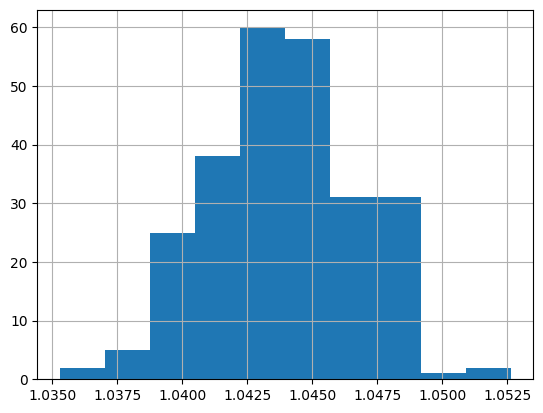

In [ ]:
df.money_overround.hist()

On paper, it's awful close to 4.5%, just like -110 spread bets.

the public getting -3.2% does indicate they're doing better than chance, a bit.

I could prove that with a random simulation.

df_money.head()

In [ ]:
df_money.columns

Index(['game_id', 'game_date', 'away_team', 'home_team', 'pregame_odds',
       'total_over_points', 'total_over_stake_percentage',
       'total_over_wager_percentage', 'total_over_odds',
       'total_over_decimal_odds', 'total_over_won', 'total_under_points',
       'total_under_stake_percentage', 'total_under_wager_percentage',
       'total_under_odds', 'total_under_decimal_odds', 'total_under_won',
       'money_away_odds', 'money_away_decimal_odds',
       'money_away_stake_percentage', 'money_away_wager_percentage',
       'money_away_won', 'money_home_odds', 'money_home_decimal_odds',
       'money_home_stake_percentage', 'money_home_wager_percentage',
       'money_home_won', 'spread_away_points', 'spread_away_odds',
       'spread_away_decimal_odds', 'spread_away_stake_percentage',
       'spread_away_wager_percentage', 'spread_away_won', 'spread_home_points',
       'spread_home_odds', 'spread_home_decimal_odds',
       'spread_home_stake_percentage', 'spread_home_wager_per

In [ ]:

some_outcomes = []
NUM_OUTCOMES = 100


for run in range(NUM_OUTCOMES):
    random_p_l = []
    # simulate taking random money line picks, and betting $100 on them
    for idx, row in df_money.iterrows():
        # for each row, flip a virtual coin to decide side to take, then record whether it made/lost money
        home_vs_away = rng.choice(["home", "away"])
        won = row[f"money_{home_vs_away}_won"]
        if won:
            random_p_l.append(row[f"money_{home_vs_away}_payout"])
        else:
            random_p_l.append(-100)
    some_outcomes.append(random_p_l)


In [61]:
outcomes = pd.Series(map(sum, some_outcomes))

<Axes: >

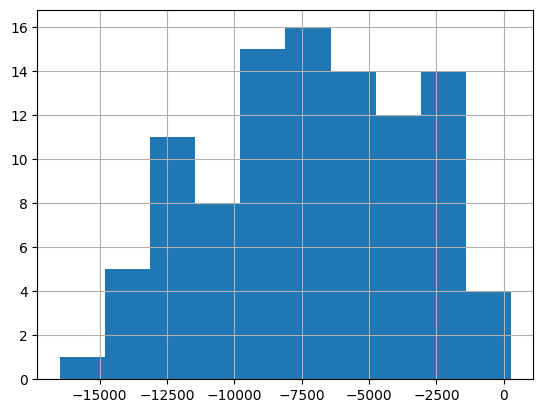

In [62]:
outcomes.hist()

so yeah, the public did better than simulation (but within one std of the mean)

In [63]:
outcomes.describe()

count      100.000000
mean     -7195.002818
std       3833.314054
min     -16474.388064
25%      -9805.142126
50%      -7136.851361
75%      -4140.351527
max        267.380500
dtype: float64

# weird pandas issue
this is for the blog

In [ ]:
df.money_home_won

0     True
0     True
0    False
0     True
0    False
     ...  
0     True
0    False
0     True
0    False
0     True
Name: money_home_won, Length: 253, dtype: object

In [ ]:
negate = ~df_money.money_home_won
negate

0    False
0     True
0     True
0    False
0     True
     ...  
0    False
0     True
0    False
0     True
0    False
Name: money_home_won, Length: 1200, dtype: bool

In [ ]:
negate.value_counts()

money_home_won
False    648
True     552
Name: count, dtype: int64

In [ ]:
sum(negate)

552

it works as expected when casting it as boolean

In [ ]:
negate2 = ~(df_money.money_home_won.astype(bool))

In [ ]:
negate2

0    False
0     True
0     True
0    False
0     True
     ...  
0    False
0     True
0    False
0     True
0    False
Name: money_home_won, Length: 1200, dtype: bool

### the concise version of the problem

In [ ]:
x = pd.Series([True, False, True])

In [ ]:
x.dtype

dtype('bool')

when I loaded my data, it ended up being an `object` type, possibly because of nulls that I later dropped?

In [ ]:
x.astype(object)

0     True
1    False
2     True
dtype: object

this mostly behaves as expected...

In [ ]:
sum(x.astype(object))

2

In [ ]:
x_o = x.astype(object)

In [ ]:
x_o[x_o == True]

0    True
2    True
dtype: object

In [ ]:
sum(x_o)

2

but something horrible happens if you negate the Series with `dtype == object`:

In [ ]:
~x_o

0    -2
1    -1
2    -2
dtype: object

In [ ]:
sum(~x_o)

-5

In [ ]:
~x_o == True

0    False
1    False
2    False
dtype: bool